In [1]:
# PIP Install
!pip install -q --upgrade transformers
!pip install -q sentencepiece ftfy regex tqdm opencv-python-headless datasets
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q torch torchvision torchaudio
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done


In [2]:
import cv2
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import torch
import time
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import T5Tokenizer, T5ForConditionalGeneration
from accelerate import Accelerator

In [3]:

!kaggle datasets download -d vishnutheepb/msrvtt -p /content/msrvtt_videos --unzip


Dataset URL: https://www.kaggle.com/datasets/vishnutheepb/msrvtt
License(s): unknown
 99% 4.24G/4.26G [00:25<00:00, 170MB/s]
100% 4.26G/4.26G [00:25<00:00, 182MB/s]


In [5]:

video_dir = "/content/msrvtt_videos/TrainValVideo"

if not os.path.exists(video_dir):
    raise ValueError(f"Video directory {video_dir} does not exist.")

# Frame extraction 
def extract_frames(video_path, num_frames=16, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        raise ValueError(f"Video {video_path} has only {total_frames} frames, which is less than the required {num_frames} frames.")
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame).resize(resize)
            frames.append(frame)
    cap.release()
    if len(frames) != num_frames:
        raise ValueError(f"Expected {num_frames} frames, but got {len(frames)} from {video_path}")
    return frames


In [6]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model = clip_model.float()

preprocess = Compose([
    Resize(224, interpolation=Image.BICUBIC),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
              std=(0.26862954, 0.26130258, 0.27577711)),
])

# Extract features 
def extract_video_features(video_path, num_frames=16):
    frames = extract_frames(video_path, num_frames=num_frames)
    frame_tensors = torch.stack([preprocess(frame) for frame in frames]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(frame_tensors)  
        video_features = image_features.mean(dim=0)  
    return video_features.float()  

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 145MiB/s]


In [7]:
# MSR-VTT dataset
print("Loading dataset...")
dataset = load_dataset("AlexZigma/msr-vtt", split="train")

captions_df = pd.DataFrame(dataset)
captions_df = captions_df[['video_id', 'caption']]


captions_df['video_path'] = captions_df['video_id'].apply(lambda x: os.path.join(video_dir, f"{x}.mp4"))
print(f"video path: {captions_df['video_path']}")

captions_df = captions_df[captions_df['video_path'].apply(os.path.exists)].reset_index(drop=True)

print(f"Total samples: {len(captions_df)}")

train_size = int(0.8 * len(captions_df))
train_captions_df = captions_df.iloc[:train_size]
test_captions_df = captions_df.iloc[train_size:]
print(f"Training samples: {len(train_captions_df)}, Testing samples: {len(test_captions_df)}")

train_captions_df = train_captions_df.sample(n=1000).reset_index(drop=True)
test_captions_df = test_captions_df.sample(n=100).reset_index(drop=True)
print(f"Training samples: {len(train_captions_df)}, Testing samples: {len(test_captions_df)}")

Loading dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

(…)-00000-of-00001-60e50ff5fbbd1bb5.parquet:   0%|          | 0.00/553k [00:00<?, ?B/s]

(…)-00000-of-00001-01bacdd7064306bc.parquet:   0%|          | 0.00/44.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6513 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/497 [00:00<?, ? examples/s]

video path: 0         /content/msrvtt_videos/TrainValVideo/video0.mp4
1         /content/msrvtt_videos/TrainValVideo/video1.mp4
2        /content/msrvtt_videos/TrainValVideo/video10.mp4
3       /content/msrvtt_videos/TrainValVideo/video100.mp4
4       /content/msrvtt_videos/TrainValVideo/video1000...
                              ...                        
6508    /content/msrvtt_videos/TrainValVideo/video995.mp4
6509    /content/msrvtt_videos/TrainValVideo/video996.mp4
6510    /content/msrvtt_videos/TrainValVideo/video997.mp4
6511    /content/msrvtt_videos/TrainValVideo/video998.mp4
6512    /content/msrvtt_videos/TrainValVideo/video999.mp4
Name: video_path, Length: 6513, dtype: object
Total samples: 6513
Training samples: 5210, Testing samples: 1303
Training samples: 1000, Testing samples: 100


In [8]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

t5_model = t5_model.float()

class VideoCaptioningModel(nn.Module):
    def __init__(self, clip_feature_dim, decoder_model, hidden_dim=512, seq_length=10):
        super(VideoCaptioningModel, self).__init__()
        self.decoder = decoder_model
        self.linear = nn.Linear(clip_feature_dim, hidden_dim * seq_length) 
        self.relu = nn.ReLU()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.proj = nn.Linear(hidden_dim * 2, hidden_dim)  

    def forward(self, input_ids, attention_mask, video_features, labels=None):
        
        video_features = video_features.float()

        mapped_features = self.relu(self.linear(video_features)) 

        # Reshaping
        total_size = mapped_features.size(0) * self.seq_length * self.hidden_dim  
        expected_size = mapped_features.numel()
        if total_size != expected_size:
            raise ValueError(f"Shape mismatch: expected size {total_size}, but got {expected_size}")

        
        batch_size = mapped_features.size(0)
        mapped_features = mapped_features.view(batch_size, self.seq_length, self.hidden_dim)  

        # Encoder attention mask 
        encoder_attention_mask = torch.ones(mapped_features.size()[:2], dtype=torch.long).to(device)

        # Token embeddings 
        text_embeddings = self.decoder.get_input_embeddings()(input_ids)  

        # Resize video embeddings 
        if mapped_features.size(1) != text_embeddings.size(1):
            video_embeddings = torch.nn.functional.interpolate(
                mapped_features.unsqueeze(0),
                size=(text_embeddings.size(1), mapped_features.size(2))
            ).squeeze(0)
        else:
            video_embeddings = mapped_features

        # print(f"Resized video embeddings: {video_embeddings.shape}")

        
        combined_embeddings = torch.cat((text_embeddings, video_embeddings), dim=-1) 
        

        
        combined_embeddings = self.proj(combined_embeddings)  
        

        updated_attention_mask = torch.ones(combined_embeddings.size()[:2], dtype=torch.long).to(device)
        

        
        encoder_outputs = self.decoder.encoder(
            inputs_embeds=combined_embeddings,  
            attention_mask=updated_attention_mask  
        )

        # Pass encoder outputs to the decoder
        decoder_outputs = self.decoder(
            input_ids=input_ids,  
            attention_mask=attention_mask,
            encoder_outputs=encoder_outputs,  
            labels=labels  
        )

        return decoder_outputs


# Initialization
clip_feature_dim = 512  
seq_length = 10  
model = VideoCaptioningModel(clip_feature_dim=clip_feature_dim, decoder_model=t5_model, seq_length=seq_length).to(device)

model = model.float()


batch = {
    'input_ids': tokenizer.encode("This is a sample caption.", return_tensors="pt").to(device),
    'attention_mask': torch.ones(1, 20).to(device),  
    'video_features': torch.randn(1, clip_feature_dim).to(device)  
}

# Forward pass with labels
labels = batch['input_ids']
outputs = model(
    input_ids=batch['input_ids'],
    attention_mask=batch['attention_mask'],
    video_features=batch['video_features'],
    labels=labels
)

print(outputs.loss)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


tensor(8.8247, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
max_length = 20  

In [10]:
'''
New Dataset
'''

# from torch.utils.data import Dataset, DataLoader

class VideoCaptionDataset(Dataset):
    def __init__(self, captions_df, tokenizer, clip_model, device, num_frames=16, max_length=20):
        self.captions_df = captions_df
        self.tokenizer = tokenizer
        self.clip_model = clip_model
        self.device = device
        self.num_frames = num_frames
        self.max_length = max_length

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        video_path = self.captions_df.iloc[idx]['video_path']
        caption = self.captions_df.iloc[idx]['caption']

        # Extract video features
        video_features = extract_video_features(video_path, num_frames=self.num_frames) 

        # Tokenize the caption as labels 
        tokens = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        labels = tokens.input_ids.squeeze(0) 

        
        input_ids = torch.tensor([[self.tokenizer.pad_token_id]], dtype=torch.long)
        attention_mask = torch.ones_like(input_ids)

        return {
            'video_features': video_features,
            'input_ids': input_ids.squeeze(0),
            'attention_mask': attention_mask.squeeze(0),
            'labels': labels
        }

# Datasets
train_dataset = VideoCaptionDataset(train_captions_df, tokenizer, clip_model, device)
test_dataset = VideoCaptionDataset(test_captions_df, tokenizer, clip_model, device)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [11]:

batch = next(iter(train_dataloader))

video_features = batch['video_features'].to(device).float()

input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['input_ids'].to(device)  

video_features = torch.autograd.Variable(video_features, requires_grad=True)

# Forward pass
model.train()
outputs = model(
    video_features=video_features,
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels
)

# loss gradients
loss = outputs.loss
print(f"Loss requires_grad: {loss.requires_grad}")
try:
    loss.backward()
    print("Backward pass succeeded.")
except Exception as e:
    print(f"Backward pass failed: {e}")


Loss requires_grad: True
Backward pass succeeded.


In [12]:
%%time
accelerator = Accelerator()

# Initialization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Model, optimizer, and data loaders
model, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
    test_dataloader
)

num_epochs = 50  
train_loss_history = []
test_loss_history = []
# best_test_loss = float('inf')
# early_stopping_patience = 5
# epochs_no_improve = 0

#Training Loop
for epoch in range(num_epochs):
    
    model.train()
    total_loss = 0
    if accelerator.is_main_process:
        start_time = time.time()
    for batch_idx, batch in enumerate(train_dataloader):
        video_features = batch['video_features'].float()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']


        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            video_features=video_features,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        if isinstance(loss, torch.Tensor):
            loss = loss.mean() 
        total_loss += loss.item()

        # Backward pass and optimization
        accelerator.backward(loss)
        optimizer.step()

        if (batch_idx + 1) % 200 == 0 and accelerator.is_local_main_process:
            print(f"Batch {batch_idx+1}/{len(train_dataloader)}, Training Loss: {loss.item()}")

    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            video_features = batch['video_features'].float()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']


            outputs = model(
                video_features=video_features,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            test_loss = outputs.loss
            if isinstance(test_loss, torch.Tensor):
                test_loss = test_loss.mean()  
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    test_loss_history.append(avg_test_loss)

    # Early Stopping Check
    # if avg_test_loss < best_test_loss:
    #     best_test_loss = avg_test_loss
    #     epochs_no_improve = 0
    #     if accelerator.is_main_process:
    #         unwrapped_model = accelerator.unwrap_model(model)
    #         torch.save(unwrapped_model.state_dict(), "best_model.pth")
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= early_stopping_patience and accelerator.is_main_process:
    #         print("Early stopping triggered.")
    #         break

    if accelerator.is_main_process:
        torch.cuda.synchronize()  
        end_time = time.time()
        print(f"Epoch {epoch+1}, "
              f"Average Training Loss: {avg_train_loss:.4f}, "
              f"Average Test Loss: {avg_test_loss:.4f}, "
              f"Time Elapsed: {end_time - start_time:.2f} seconds")

print("Training complete.")


Epoch 1, Average Training Loss: 4.4038, Average Test Loss: 2.3943, Time Elapsed: 292.05 seconds
Epoch 2, Average Training Loss: 2.5778, Average Test Loss: 2.2351, Time Elapsed: 291.21 seconds
Epoch 3, Average Training Loss: 2.3669, Average Test Loss: 2.1680, Time Elapsed: 290.05 seconds
Epoch 4, Average Training Loss: 2.2791, Average Test Loss: 2.1300, Time Elapsed: 290.10 seconds
Epoch 5, Average Training Loss: 2.2079, Average Test Loss: 2.1017, Time Elapsed: 289.99 seconds
Epoch 6, Average Training Loss: 2.1485, Average Test Loss: 2.0857, Time Elapsed: 290.06 seconds
Epoch 7, Average Training Loss: 2.1069, Average Test Loss: 2.0684, Time Elapsed: 290.77 seconds
Epoch 8, Average Training Loss: 2.0625, Average Test Loss: 2.0615, Time Elapsed: 290.64 seconds
Epoch 9, Average Training Loss: 2.0124, Average Test Loss: 2.0547, Time Elapsed: 291.01 seconds
Epoch 10, Average Training Loss: 1.9903, Average Test Loss: 2.0455, Time Elapsed: 290.98 seconds
Epoch 11, Average Training Loss: 1.9410

KeyboardInterrupt: 

In [13]:
def generate_caption(model, tokenizer, video_path, clip_model, device, num_frames=16, max_length=20):
    model.eval()
    with torch.no_grad():
        # Extract video features
        video_features = extract_video_features(video_path, num_frames=num_frames).to(device).float()

        if model.decoder.config.decoder_start_token_id is None:
            model.decoder.config.decoder_start_token_id = tokenizer.pad_token_id

        input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        text_embeddings = model.decoder.get_input_embeddings()(input_ids)  

        # Process video features
        mapped_features = model.relu(model.linear(video_features.unsqueeze(0)))
        mapped_features = mapped_features.view(1, model.seq_length, model.hidden_dim)  

        if mapped_features.size(1) != text_embeddings.size(1):
            mapped_features = torch.nn.functional.interpolate(
                mapped_features.unsqueeze(0),
                size=(text_embeddings.size(1), mapped_features.size(2))
            ).squeeze(0)

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, mapped_features), dim=-1)  
        combined_embeddings = model.proj(combined_embeddings) 
        updated_attention_mask = torch.ones(combined_embeddings.size()[:2], dtype=torch.long).to(device)

        
        encoder_outputs = model.decoder.encoder(
            inputs_embeds=combined_embeddings,
            attention_mask=updated_attention_mask
        )

        # Generate tokens
        generated_ids = model.decoder.generate(
            encoder_outputs=encoder_outputs,
            max_length=64,
            num_beams=5,
            early_stopping=True,
            do_sample=True,
            top_p=0.9,
            top_k=80,
            temperature=1.0,
        )

        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return caption

# Inference:
for idx in range(10):
    video_path = test_captions_df.iloc[idx]['video_path']
    true_caption = test_captions_df.iloc[idx]['caption']
    generated_caption = generate_caption(model, tokenizer, video_path, clip_model, device)
    print(f"Video {idx+1}:")
    print(f"True Caption: {true_caption}")
    print(f"Generated Caption: {generated_caption}\n")


Video 1:
True Caption: a man is singing and playing guitar on stage
Generated Caption: a man is playing a video game

Video 2:
True Caption: a cartoon game of a truck jumping across a bridge
Generated Caption: a clip from a movie is playing

Video 3:
True Caption: a clip about crops being contaminated in ireland
Generated Caption: a clip from a movie is playing

Video 4:
True Caption: a black woman is constantly calling a white girl a white girl
Generated Caption: a man in a black suit talking in a video game

Video 5:
True Caption: a laser factory in china is showcased in great detail
Generated Caption: there is a man is talking about a new product

Video 6:
True Caption: a soldier is running through a war zone with a gun on his arm
Generated Caption: a clip from a movie is playing

Video 7:
True Caption: a reporter on a television news station talks about donald trump s campaign
Generated Caption: a clip from a news show

Video 8:
True Caption: a man is playing the guitar and talking

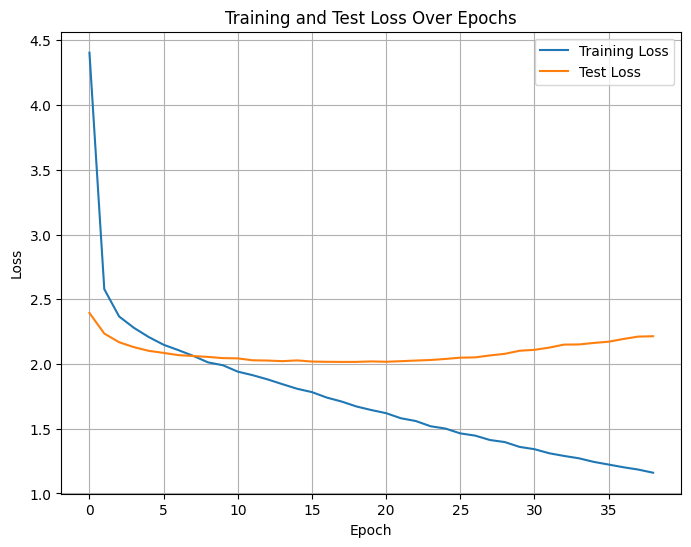

In [14]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def generate_caption(model, tokenizer, video_path, clip_model, device, num_frames=16, max_length=20):
    model.eval()
    with torch.no_grad():
        # Extract video features
        video_features = extract_video_features(video_path, num_frames=num_frames).to(device).float()

        if model.decoder.config.decoder_start_token_id is None:
            model.decoder.config.decoder_start_token_id = tokenizer.pad_token_id

        input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        text_embeddings = model.decoder.get_input_embeddings()(input_ids)  

        # Process video features
        mapped_features = model.relu(model.linear(video_features.unsqueeze(0)))
        mapped_features = mapped_features.view(1, model.seq_length, model.hidden_dim)  

        if mapped_features.size(1) != text_embeddings.size(1):
            mapped_features = torch.nn.functional.interpolate(
                mapped_features.unsqueeze(0),
                size=(text_embeddings.size(1), mapped_features.size(2))
            ).squeeze(0)

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, mapped_features), dim=-1) 
        combined_embeddings = model.proj(combined_embeddings) 
        updated_attention_mask = torch.ones(combined_embeddings.size()[:2], dtype=torch.long).to(device)

        encoder_outputs = model.decoder.encoder(
            inputs_embeds=combined_embeddings,
            attention_mask=updated_attention_mask
        )

        # Generate tokens
        generated_ids = model.decoder.generate(
            encoder_outputs=encoder_outputs,
            max_length=64,
            num_beams=5,
            early_stopping=True,
            do_sample=True,
            top_p=0.9,
            top_k=80,
            temperature=1.0,
        )

        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return caption

# Inference :
for idx in range(50):
    video_path = test_captions_df.iloc[idx]['video_path']
    true_caption = test_captions_df.iloc[idx]['caption']
    generated_caption = generate_caption(model, tokenizer, video_path, clip_model, device)
    print(f"Video {idx+1}:")
    print(f"True Caption: {true_caption}")
    print(f"Generated Caption: {generated_caption}\n")


Video 1:
True Caption: a man is singing and playing guitar on stage
Generated Caption: a clip from a movie is playing

Video 2:
True Caption: a cartoon game of a truck jumping across a bridge
Generated Caption: a clip from a movie is playing

Video 3:
True Caption: a clip about crops being contaminated in ireland
Generated Caption: a man is talking

Video 4:
True Caption: a black woman is constantly calling a white girl a white girl
Generated Caption: a group of people are talking to each other

Video 5:
True Caption: a laser factory in china is showcased in great detail
Generated Caption: a man in a white shirt is talking in front of a car

Video 6:
True Caption: a soldier is running through a war zone with a gun on his arm
Generated Caption: a clip from a movie is playing

Video 7:
True Caption: a reporter on a television news station talks about donald trump s campaign
Generated Caption: a clip from a news show

Video 8:
True Caption: a man is playing the guitar and talking about tr